In [2]:
import numpy as np
import pandas as pd

In [54]:
item_cats_df = pd.read_csv('../data/input/item_categories.csv')
item_df = pd.read_csv('../data/input/items.csv')
sales_train_df = pd.read_csv('../data/input/sales_train.csv')
sample_submission_df = pd.read_csv('../data/input/sample_submission.csv')
shops_df = pd.read_csv('../data/input/shops.csv')

test = pd.read_csv('../data/input/test.csv')

date_block_num:連続した月の番号。　2013年1月=0, 2013年2月=1, ..., 2015年10月=33  
item_cnt_day:商品の売れた数。目的変数。  
item_id:商品個別の識別子  

In [55]:
item_merge_df = pd.merge(item_df, item_cats_df, on='item_category_id', how='inner')

# 商品名、カテゴリ名、日付、価格のdataframeを作成
item_price_df = pd.merge(item_merge_df, sales_train_df, on='item_id', how='inner')

train = item_price_df.drop(['item_name', 'item_category_name'], axis=1)
display(train.head(10))

,item_id,item_category_id,date,date_block_num,shop_id,item_price,item_cnt_day
0,0,40,01.09.2014,20,54,58.0,1.0
1,2,40,24.08.2014,19,54,58.0,1.0
2,2,40,12.11.2014,22,54,58.0,1.0
3,3,40,05.07.2014,18,54,100.0,1.0
4,3,40,26.08.2014,19,54,58.0,1.0
5,4,40,19.09.2014,20,54,58.0,1.0
6,5,40,14.12.2014,23,54,28.0,1.0
7,6,40,19.07.2014,18,54,100.0,1.0
8,7,40,14.12.2014,23,54,28.0,1.0
9,8,40,26.08.2014,19,54,58.0,1.0


# 前処理

In [62]:
train = sales_train_df.copy()
# 日付型に変換
train['date'] = pd.to_datetime(train['date'])

# 外れ値の確認
reference:https://www.kaggle.com/dlarionov/feature-engineering-xgboost

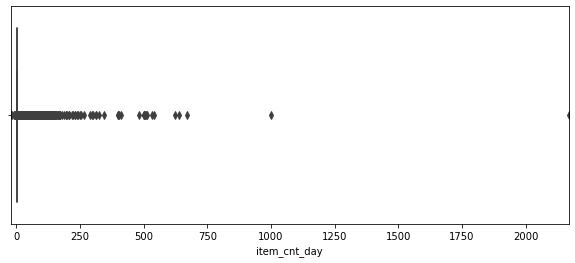

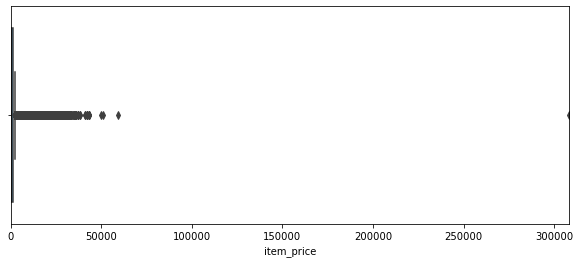

In [56]:
# 外れ値の確認
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.xlim(train.item_cnt_day.min(), train.item_cnt_day.max())
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max())
sns.boxplot(x=train.item_price)

# 外れ値の除去

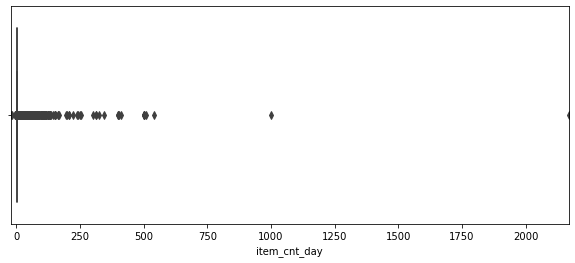

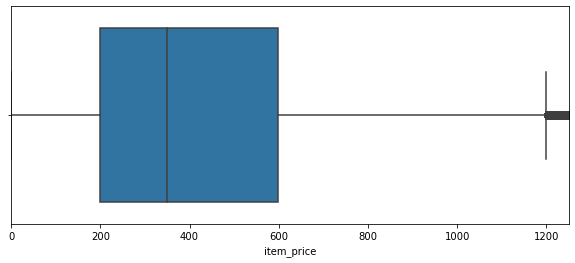

In [57]:
train = train[train.item_cnt_day < 100000]
train = train[train.item_price < 1250]

plt.figure(figsize=(10,4))
plt.xlim(train.item_cnt_day.min(), train.item_cnt_day.max())
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max())
sns.boxplot(x=train.item_price)

In [60]:
train[train.item_price < 0]

,item_id,item_category_id,date,date_block_num,shop_id,item_price,item_cnt_day
954805,2973,19,15.05.2013,4,32,-1.0,1.0


In [63]:
# 商品価格が負のデータを同じ条件の他のデータ群の中央値で置換
median = train[(train.shop_id==32)&\
               (train.item_id==2973)&\
               (train.date_block_num==4)&\
               (train.item_price>0)].item_price.median()
train.loc[train.item_price < 0, 'item_price'] = median

# データ確認

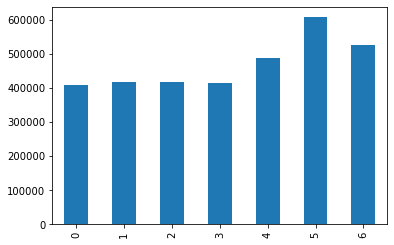

In [13]:
# 曜日を追加
# Sun:0, Mon:1, Tue:2, Wed:3, Thu:4, Fri:5, Sat:6
train['DOW'] = train['date'].dt.dayofweek

# 曜日毎の売上数
train.groupby('DOW').\
item_cnt_day.sum().reset_index().item_cnt_day.plot.bar()

# 1か月の合計を予測すればよいので、あくまで確認だけ

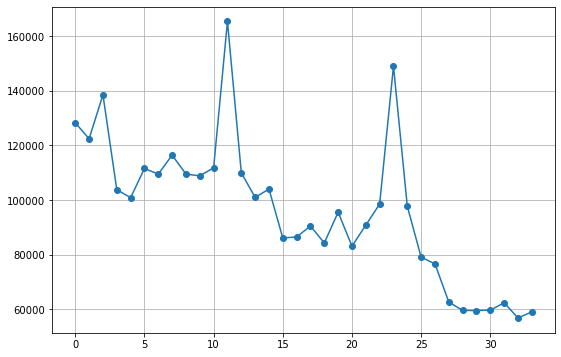

In [14]:
# 月ごとの売上数
train.groupby('date_block_num').\
item_cnt_day.sum().reset_index().item_cnt_day.plot(style='o-', figsize=(9, 6), grid=True)

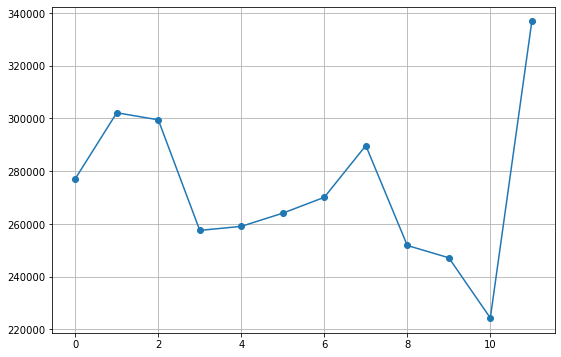

In [15]:
# 月を追加
train['month'] = train['date'].dt.month
train.groupby('month').\
item_cnt_day.sum().reset_index().item_cnt_day.plot(style='o-', figsize=(9,6), grid=True)

In [22]:
# 日付順に整列
train.sort_values('date', ascending=True, inplace=True)
train.reset_index(drop=True, inplace=True)
display(train)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,DOW,month
0,2013-01-01,0,7,6495,699.0,1.0,1,1
1,2013-01-01,0,27,19473,249.0,1.0,1,1
2,2013-01-01,0,19,21422,149.0,1.0,1,1
3,2013-01-01,0,28,1958,99.0,1.0,1,1
4,2013-01-01,0,28,1675,299.0,1.0,1,1
...,...,...,...,...,...,...,...,...
2865496,2015-12-10,33,6,18719,49.0,1.0,3,12
2865497,2015-12-10,33,6,18885,199.0,1.0,3,12
2865498,2015-12-10,33,31,9927,399.0,1.0,3,12
2865499,2015-12-10,33,55,6951,2299.0,1.0,3,12
